 # 03: Hyperparameter Tuning & Model Finalization

 **Objective:** To take the best-performing baseline model, **Random Forest**, fine-tune its hyperparameters for optimal performance, and serialize the final model and pre-processing objects for deployment.

 **Workflow:**
 1.  **Setup & Load Data**: Import libraries and load the **cleaned** dataset from Phase 1.
 2.  **Data Preparation**: Replicate the exact preprocessing pipeline (log transform, encoding, splitting, scaling) from Phase 2 for consistency.
 3.  **Hyperparameter Tuning**: Use `RandomizedSearchCV` to efficiently search for the best combination of hyperparameters for the Random Forest model.
 4.  **Final Model Evaluation**: Evaluate the tuned model on the held-out test set to confirm its performance.
 5.  **Model Serialization**: Save the final, optimized model and the data scaler to disk for use in the web application.
 6.  **Conclusion**: Summarize the final outcome of the project's modeling phase.
 ---

In [1]:
# ==============================================================================
# 1. SETUP & LOAD CLEANED DATA
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configure settings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# --- Dynamic Pathing ---
from pathlib import Path
current_dir = Path.cwd()
base_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
# --- Pointing to the PROCESSED data from Notebook 01 ---
data_path = base_dir / 'data' / 'processed' / 'water_quality_cleaned.csv'
models_dir = base_dir / 'models'
reports_dir = base_dir / 'reports' / 'figures'

# Create directories if they don't exist
models_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)


# --- Load Dataset ---
try:
    df = pd.read_csv(data_path)
    print(f"✅ Cleaned dataset loaded successfully from '{data_path}'. Shape: {df.shape}")
except FileNotFoundError:
    print(f"❌ Error: Cleaned dataset not found. Please run the `01_eda...` notebook first to generate it.")
    df = pd.DataFrame()

✅ Cleaned dataset loaded successfully from 'c:\Users\Fernado\Desktop\ML_Project\data\processed\water_quality_cleaned.csv'. Shape: (18860, 24)


 ## 2. Data Preparation
 ---
 This section repeats the complete data preparation pipeline from the previous notebook. This ensures that the data fed into our final model is processed in exactly the same way.


In [2]:
# ==============================================================================
# 2. DATA PREPARATION
# ==============================================================================
if not df.empty:
    # 2.1. Feature Selection, Log Transformation, and Target Encoding
    features = ['EC', 'Cl', 'TDS', 'Na']
    target = 'Water Quality Classification'
    X = df[features].copy()
    y = df[target]
    
    for col in features:
        X[col] = np.log1p(X[col])
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    print("✅ Feature selection, transformation, and encoding complete.")

    # 2.2. Stratified Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("✅ Data splitting and scaling complete.")

✅ Feature selection, transformation, and encoding complete.
✅ Data splitting and scaling complete.


 ## 3. Hyperparameter Tuning
 ---
 We use `RandomizedSearchCV` to efficiently search for the best hyperparameters for our **Random Forest** model. We optimize for the `f1_macro` score, which is a robust metric for imbalanced classification tasks.


In [3]:
# ==============================================================================
# 3. HYPERPARAMETER TUNING
# ==============================================================================
if not df.empty:
    # --- 3.1. Define the Hyperparameter Grid for Random Forest ---
    param_distributions = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # --- 3.2. Set up and Run RandomizedSearchCV ---
    rf_model = RandomForestClassifier(random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_distributions,
        n_iter=50,  # Try 50 different combinations
        cv=5,       # 5-fold cross-validation
        scoring='f1_macro',
        n_jobs=-1,  # Use all available CPU cores
        random_state=42,
        verbose=2   # Show progress
    )

    print("🚀 Starting hyperparameter tuning for Random Forest...")
    random_search.fit(X_train_scaled, y_train)
    print("✅ Tuning complete.")

🚀 Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Tuning complete.


 ## 4. Final Model Evaluation
 ---
 We now evaluate the `best_model` found during the search on our held-out test set. This gives us the final performance metrics for our optimized model.



🏆 Best Hyperparameters Found:
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

⭐ Best Macro-F1 Score from Cross-Validation: 0.9624

✅ Final Results for Tuned Random Forest Model:
   Accuracy: 0.9708
   Classification Report:
                              precision    recall  f1-score   support
     
                   Excellent       0.99      0.96      0.97       149
                        Good       0.95      0.93      0.94       307
                        Poor       0.96      0.97      0.97      1056
     Unsuitable for Drinking       0.99      0.99      0.99      1320
     Very Poor yet Drinkable       0.96      0.96      0.96       940
     
                    accuracy                           0.97      3772
                   macro avg       0.97      0.96      0.97      3772
                weighted avg       0.97      0.97      0.97      3772
     


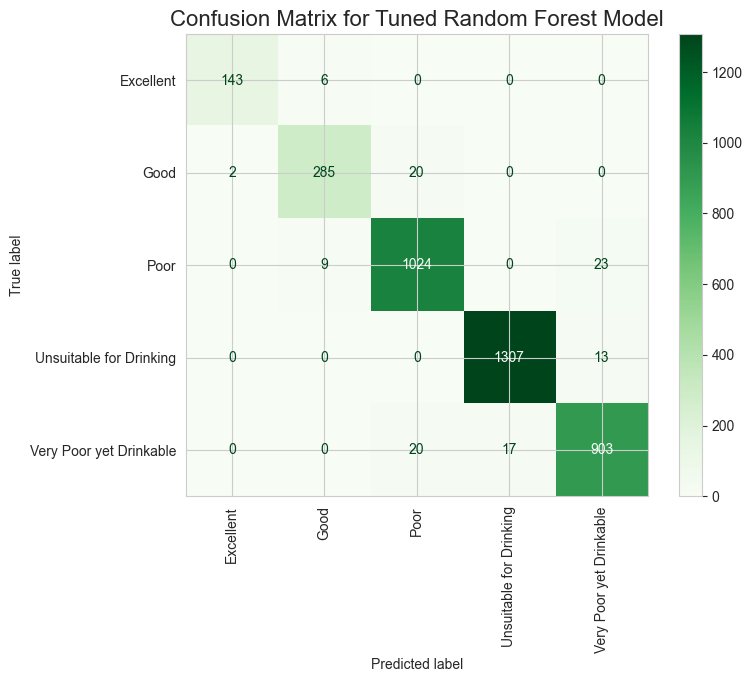


✅ Final confusion matrix saved to 'c:\Users\Fernado\Desktop\ML_Project\reports\figures\confusion_matrix_Tuned_Random_Forest.png'


In [4]:
# ==============================================================================
# 4. FINAL MODEL EVALUATION
# ==============================================================================
if 'random_search' in locals():
    # --- 4.1. Analyze Tuning Results ---
    print("\n🏆 Best Hyperparameters Found:")
    print(random_search.best_params_)
    print(f"\n⭐ Best Macro-F1 Score from Cross-Validation: {random_search.best_score_:.4f}")
    
    # The best model found by the search
    best_model = random_search.best_estimator_

    # --- 4.2. Evaluate the Tuned Model on the Test Set ---
    y_pred_tuned = best_model.predict(X_test_scaled)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    report_tuned = classification_report(y_test, y_pred_tuned, target_names=class_names)

    print("\n✅ Final Results for Tuned Random Forest Model:")
    print(f"   Accuracy: {accuracy_tuned:.4f}")
    print("   Classification Report:")
    for line in report_tuned.split('\n'):
            print(f"     {line}")

    # --- 4.3. Visualize the Final Confusion Matrix ---
    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp_tuned.plot(ax=ax, cmap='Greens', xticks_rotation='vertical')
    ax.set_title('Confusion Matrix for Tuned Random Forest Model', fontsize=16)
    
    cm_path_tuned = reports_dir / 'confusion_matrix_Tuned_Random_Forest.png'
    plt.savefig(cm_path_tuned, bbox_inches='tight')
    plt.show()
    print(f"\n✅ Final confusion matrix saved to '{cm_path_tuned}'")

 ## 5. Model Serialization
 ---
 The final step is to save our work. We serialize and save two crucial components for our web application:
 1.  **The Tuned Model**: The `best_model` object itself, ready for making future predictions.
 2.  **The Scaler**: The `MinMaxScaler` object. This is **critical** because any new user input must be scaled in exactly the same way as the training data.


In [5]:
# ==============================================================================
# 5. MODEL SERIALIZATION
# ==============================================================================
if 'best_model' in locals() and 'scaler' in locals():
    # Define file paths consistent with the project structure
    model_path = models_dir / 'final_model.pkl'
    scaler_path = models_dir / 'scaler.pkl'

    # Save the final model using pickle
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"💾 Final model saved to: '{model_path}'")

    # Save the scaler
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"💾 Scaler saved to: '{scaler_path}'")

💾 Final model saved to: 'c:\Users\Fernado\Desktop\ML_Project\models\final_model.pkl'
💾 Scaler saved to: 'c:\Users\Fernado\Desktop\ML_Project\models\scaler.pkl'


## 6. Conclusion
---
This notebook successfully concludes the entire modeling phase of the project.

We began by taking the best-performing model from our baseline tests, **Random Forest**, and proceeded to fine-tune its hyperparameters. Using `RandomizedSearchCV`, we efficiently searched for an optimal set of parameters, validating the performance with 5-fold cross-validation and optimizing for a robust `Macro F1-Score`.

The key outcomes of this process are:

1.  **Optimal Model Identified**: The tuning process identified a set of hyperparameters that resulted in a highly stable model, achieving an excellent **Macro F1-Score of 0.9624** during cross-validation.

2.  **Confirmed High Performance**: When evaluated on the final, held-out test set, the tuned model achieved an outstanding **accuracy of 97.08%**. The detailed classification report confirms that the model is not only accurate but also balanced, performing exceptionally well across all five water quality classes.

3.  **Production-Ready Artifacts**: The two most critical components for deployment have been successfully created and saved:
    * `models/final_model.pkl`: The final, optimized Random Forest model.
    * `models/scaler.pkl`: The `MinMaxScaler` fitted on the training data.

The project has now progressed from raw data to a fine-tuned, serialized machine learning model ready for real-world application. The next and final step is to build the user-facing web application in Streamlit that will use these saved artifacts to make live predictions.